In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.svm import SVC

from darwin.config import (
    PROCESSED_DATA_DIR, 
    RANDOM_STATE, 
    CRITERION, 
    MAX_DEPTH, 
    CLASS_WEIGHT, 
    FEATURE_NUM
)

In [26]:
input_path = PROCESSED_DATA_DIR / 'preprocessed_data.csv'

In [27]:
df = pd.read_csv(input_path)

In [28]:
def select_feature_imp(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features based on the 
    feature_importance_ of a RandomForestClassifier
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and the features
    X = df.drop("class", axis='columns')
    y = df["class"]


    # TODO: Run permutation importance to select most important features
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
    )
    """
    
    # Train the Forest
    forest = RandomForestClassifier(n_estimators=100,
                                random_state=RANDOM_STATE,
                                criterion=CRITERION,
                                max_depth=MAX_DEPTH,
                                class_weight=CLASS_WEIGHT)
    forest.fit(X, y)

    
    # Get the feature importance
    feature_imp = pd.Series(forest.feature_importances_, index=X.columns)
    feature_imp = feature_imp.sort_values(ascending=False)

    selected_features = feature_imp.head(n).index.tolist()

    return selected_features

In [29]:
def select_anova(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features based on the 
    ANOVA F-Value from SelectKBest
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and the features
    X = df.drop("class", axis='columns')
    y = df["class"]

    # Fit the selector to the data
    selector = SelectKBest(f_classif, k=n)
    selector.fit(X, y)

    # Get the selected features with highest f-value
    selected_indices = np.argsort(selector.scores_)[::-1][:n]
    selected_features = X.columns[selected_indices].tolist()
    
    return selected_features

In [30]:
def select_rfe(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features selected
    by Recursive Feature Elimination with a Support Vector Classifier
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    # Splits the target and and features
    X = df.drop("class", axis='columns')
    y = df["class"]

    # Fit the selector to the data
    estimator = SVC(kernel="linear")
    selector = RFE(estimator, n_features_to_select=n, step=1)
    selector = selector.fit(X, y)

    selected_features = X.columns[selector.support_].tolist()

    return selected_features

In [58]:
import shap
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

def select_shap(df: pd.DataFrame, n: int) -> list[str]:
    """
    Given a DataFrame, returns the n most important features selected
    by SHAP
        df: pd.DataFrame
            DataFrame with the data
        n: int
            Number of features to return
        return: list
            List with the n most important features
    """
    gdb = GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        n_estimators=50,
        max_depth=7,
        criterion='friedman_mse',
        max_features='log2',
        min_samples_split=10,
        random_state=RANDOM_STATE
    )


    gdb = HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.2,
        max_iter=50,
        max_depth=3,
        random_state=RANDOM_STATE
    )
    
    X = df.drop("class", axis='columns')
    y = df["class"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

    gdb.fit(X_train, y_train)

    explainer = shap.TreeExplainer(gdb)

    # Calculate SHAP values for the entire test set
    shap_values = explainer.shap_values(X_train)
    # Calculate the mean absolute SHAP values for each feature
    shap_importance = pd.DataFrame({
        "feature": X_train.columns,
        "importance": np.abs(shap_values).mean(axis=0)
    })

    # Sort features by importance in descending order
    shap_importance = shap_importance.sort_values(by="importance", ascending=False)

    # Select the top n features
    top_features = shap_importance.head(n)["feature"].tolist()
    return top_features

In [50]:
select_shap(df, FEATURE_NUM)

['total_time23',
 'air_time23',
 'total_time17',
 'paper_time23',
 'pressure_mean5',
 'air_time17',
 'air_time7',
 'total_time18',
 'air_time16',
 'air_time2',
 'total_time13',
 'mean_speed_in_air17',
 'mean_speed_in_air25',
 'pressure_mean7',
 'air_time24',
 'total_time22',
 'gmrt_on_paper10',
 'num_of_pendown19',
 'paper_time17',
 'total_time12']

In [40]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

loss = ['log_loss', 'exponential']
learning_rate = [0.01, 0.1, 0.2]
n_estimators = [50, 100, 200]
max_depth = [3, 5, 7]
criterion = ['friedman_mse', 'squared_error']
max_features = ['sqrt', 'log2']
min_samples_split = [2, 5, 10]

param_grid = {
    'loss': loss,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features,
    'min_samples_split': min_samples_split
}
X = df.drop("class", axis='columns')
y = df["class"]

# Create a HistGradientBoostingClassifier
gb_model = GradientBoostingClassifier(random_state=42)
# Perform grid search with cross-validation
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the model to the data
gb_grid_search.fit(X, y)
# Get the best parameters
best_params = gb_grid_search.best_params_
# Get the best estimator
best_estimator = gb_grid_search.best_estimator_
# Get the best score
best_score = gb_grid_search.best_score_

In [ ]:
best_params = gb_grid_search.best_params_
# Get the best estimator
best_estimator = gb_grid_search.best_estimator_
# Get the best score
best_score = gb_grid_search.best_score_

best_params


{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_split': 10,
 'n_estimators': 50}

In [56]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

loss = ['log_loss']
learning_rate = [0.01, 0.1, 0.2]
max_depth = [3, 5, 7]
max_features = ['sqrt', 'log2']

param_grid = {
    'loss': loss,
    'learning_rate': learning_rate,
    'max_iter': [50, 100, 200],
    'max_depth': max_depth,
}
X = df.drop("class", axis='columns')
y = df["class"]

# Create a HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier(random_state=42)
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=hgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit the model to the data
grid_search.fit(X, y)
# Get the best parameters
best_params = grid_search.best_params_
# Get the best estimator
best_estimator = grid_search.best_estimator_
# Get the best score
best_score = grid_search.best_score_

In [ ]:
best_params


{'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 3, 'max_iter': 50}

In [53]:
import shap
from sklearn.ensemble import GradientBoostingClassifier
shap.initjs()
lgbm_model = GradientBoostingClassifier(random_state=42)

X = df.drop("class", axis='columns')
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)


lgbm_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

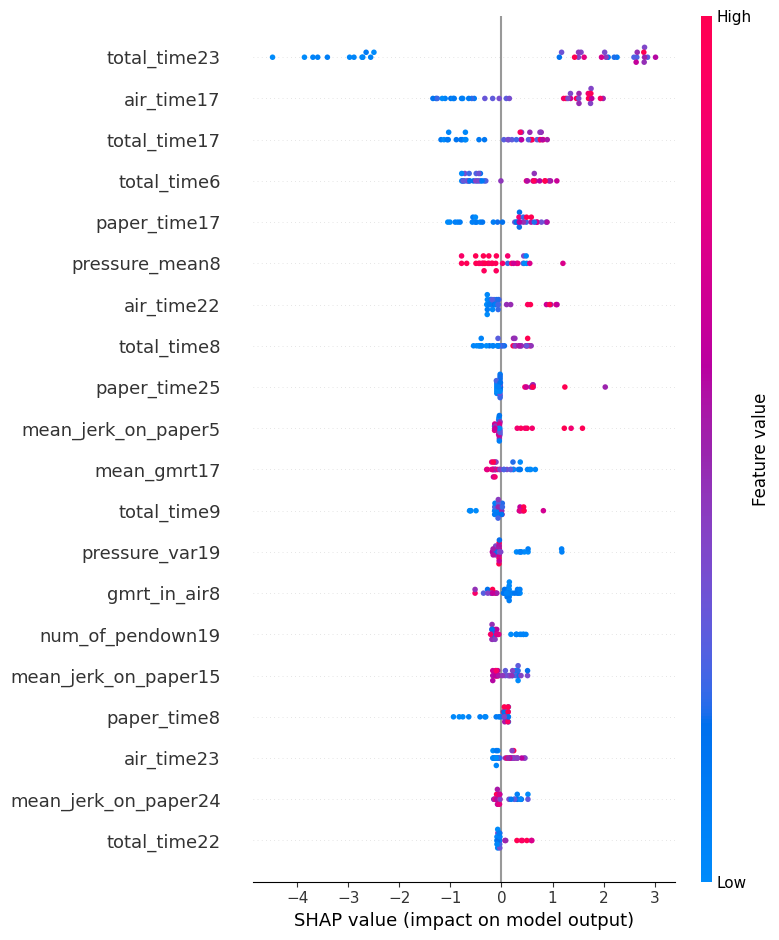

In [54]:
# Initialize the SHAP explainer with your LightGBM model
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for the entire test set
shap_values = explainer.shap_values(X_test)

# Plot the summary plot for the SHAP values
shap.summary_plot(shap_values, X_test)

In [55]:
# Calculate the mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": np.abs(shap_values).mean(axis=0)
})

# Sort features by importance in descending order
shap_importance = shap_importance.sort_values(by="importance", ascending=False)

# Select the top n features
top_features = shap_importance.head(20)["feature"].tolist()
print(f"Top {20} features: {top_features}")

Top 20 features: ['total_time23', 'air_time17', 'total_time17', 'total_time6', 'paper_time17', 'pressure_mean8', 'air_time22', 'total_time8', 'paper_time25', 'mean_jerk_on_paper5', 'mean_gmrt17', 'total_time9', 'pressure_var19', 'gmrt_in_air8', 'num_of_pendown19', 'mean_jerk_on_paper15', 'paper_time8', 'air_time23', 'mean_jerk_on_paper24', 'total_time22']


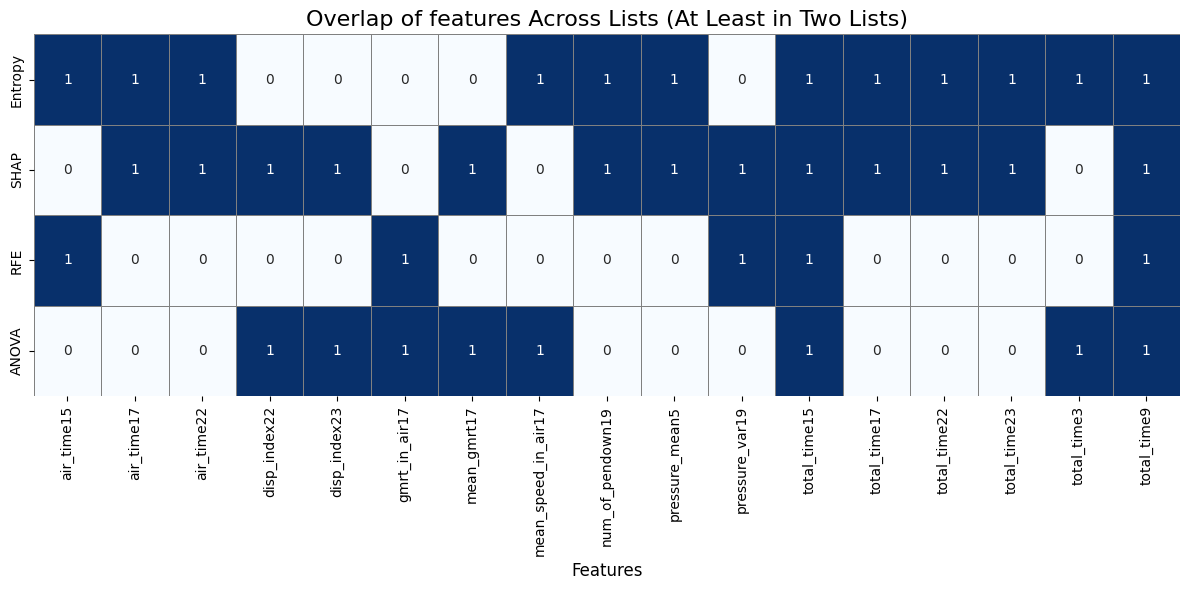

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_list_overlap(list_a, list_b, list_c, list_d):
    # Combine all unique strings from the lists
    all_strings = sorted(set(list_a + list_b + list_c + list_d))

    # Create a DataFrame to represent the presence of strings in each list
    data = {
        "Entropy": [1 if string in list_a else 0 for string in all_strings],
        "SHAP": [1 if string in list_b else 0 for string in all_strings],
        "RFE": [1 if string in list_c else 0 for string in all_strings],
        "ANOVA": [1 if string in list_d else 0 for string in all_strings],
    }
    df = pd.DataFrame(data, index=all_strings)

    # Filter strings that exist in at least two lists
    df = df[df.sum(axis=1) >= 2]

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray", annot=True, fmt="d")

    # Customize the plot
    plt.title("Overlap of features Across Lists (At Least in Two Lists)", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    #plt.ylabel("Lists", fontsize=12)
    #plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    plt.show()

# Example lists
list_a = select_feature_imp(df, FEATURE_NUM)
list_b = select_shap(df, FEATURE_NUM)
list_c = select_rfe(df, FEATURE_NUM)
list_d = select_anova(df, FEATURE_NUM)

# Call the function to plot the overlap
plot_list_overlap(list_a, list_b, list_c, list_d)